# **Model Zoo -- Convolutional Variational Autoencoder**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Architecture
num_features = 784
num_latent = 15

## **MNIST dataset**

In [4]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [5]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [7]:
class ConvVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent):
        super(ConvVariationalAutoencoder, self).__init__()
        
        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        self.dec_linear_1 = torch.nn.Linear(num_latent, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features):
        x = self.enc_conv_1(features)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        return z_mean, z_log_var, encoded, decoded

In [8]:
torch.manual_seed(random_seed)
model = ConvVariationalAutoencoder(num_features, num_latent)
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## **Training phase**

In [10]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)

        z_mean, z_log_var, encoded, decoded = model(features)

        kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()

        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 70487.2812
Epoch: 001/010 | Batch 050/469 | Cost: 69359.9375
Epoch: 001/010 | Batch 100/469 | Cost: 41370.0859
Epoch: 001/010 | Batch 150/469 | Cost: 31724.5137
Epoch: 001/010 | Batch 200/469 | Cost: 29105.3672
Epoch: 001/010 | Batch 250/469 | Cost: 27777.1426
Epoch: 001/010 | Batch 300/469 | Cost: 26178.1973
Epoch: 001/010 | Batch 350/469 | Cost: 25514.7012
Epoch: 001/010 | Batch 400/469 | Cost: 26492.5664
Epoch: 001/010 | Batch 450/469 | Cost: 25041.7363
Time elapsed: 0.68 min
Epoch: 002/010 | Batch 000/469 | Cost: 25851.5938
Epoch: 002/010 | Batch 050/469 | Cost: 24270.8613
Epoch: 002/010 | Batch 100/469 | Cost: 24281.2070
Epoch: 002/010 | Batch 150/469 | Cost: 24920.4023
Epoch: 002/010 | Batch 200/469 | Cost: 24212.5840
Epoch: 002/010 | Batch 250/469 | Cost: 23521.2773
Epoch: 002/010 | Batch 300/469 | Cost: 22890.7734
Epoch: 002/010 | Batch 350/469 | Cost: 22058.1055
Epoch: 002/010 | Batch 400/469 | Cost: 22652.3594
Epoch: 002/010 | Batch 450/

## **Evaluation**

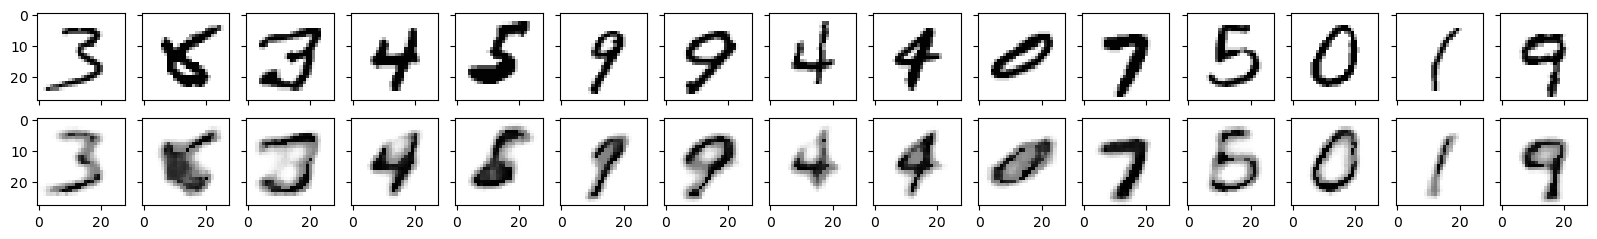

In [11]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')

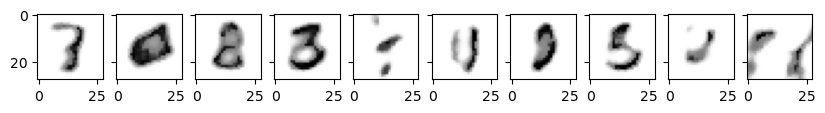

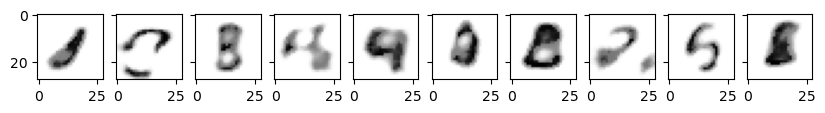

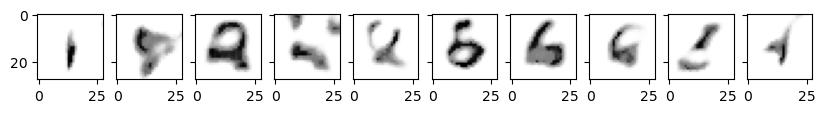

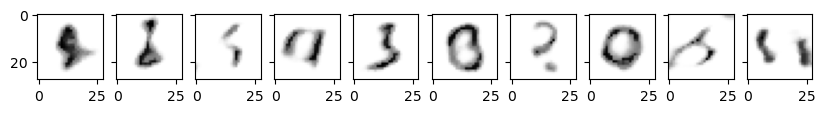

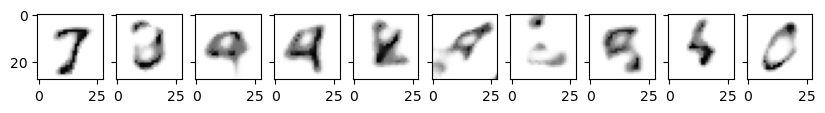

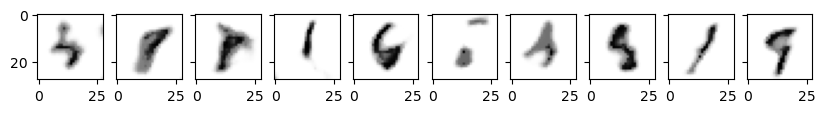

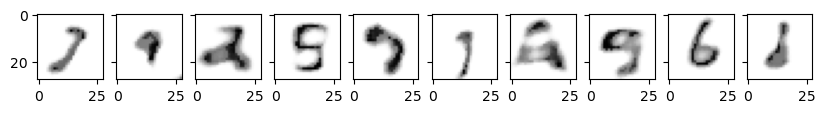

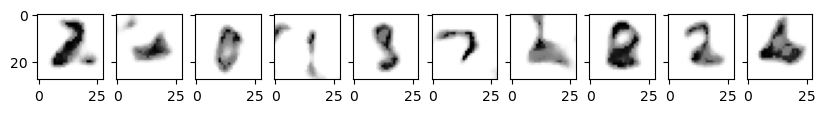

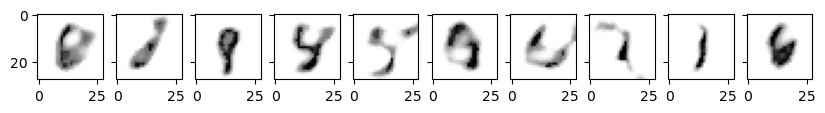

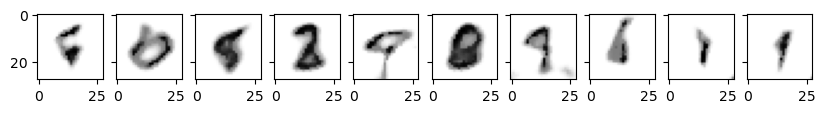

In [12]:
for i in range(10):
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')
        
    plt.show()